# Ramp Up Model Size

- I want to measure accuracy on all point with these models, and get things a bit streamlined
- Minibatches and training on all examples across the board too

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000


b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
np.random.seed(55)
num_points_to_sample=10000 #10000
belgium_coords_sample=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords_sample=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]
X_sample=np.vstack((netherlands_coords_sample, belgium_coords_sample))
y_sample=np.concatenate((np.zeros(len(belgium_coords_sample)), np.ones(len(netherlands_coords_sample)))).astype('int')
X_sample = torch.FloatTensor(X_sample)
y_sample = torch.tensor(y_sample)

#Skip sampling train on all. 
belgium_coords=belgium_coords_all
netherlands_coords=netherlands_coords_all

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

In [4]:
X_tensor.shape, y_tensor.shape, X_sample.shape, y_sample.shape

(torch.Size([855665, 2]),
 torch.Size([855665]),
 torch.Size([20000, 2]),
 torch.Size([20000]))

In [5]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig=plt.figure(0,(6,6))
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')


In [7]:
num_epochs=200
random_seed=25

## [8, 8]

In [8]:
device='cpu'
batch_size = 512

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([8, 8]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/200], Loss: 0.1690, Accuracy: 0.8748
Epoch [20/200], Loss: 0.1678, Accuracy: 0.8741
Epoch [30/200], Loss: 0.1672, Accuracy: 0.8743
Epoch [40/200], Loss: 0.1670, Accuracy: 0.8914
Epoch [50/200], Loss: 0.1668, Accuracy: 0.8729
Epoch [60/200], Loss: 0.1665, Accuracy: 0.8825
Epoch [70/200], Loss: 0.1663, Accuracy: 0.8742
Epoch [80/200], Loss: 0.1661, Accuracy: 0.8928
Epoch [90/200], Loss: 0.1655, Accuracy: 0.8609
Epoch [100/200], Loss: 0.1655, Accuracy: 0.8820
Epoch [110/200], Loss: 0.1651, Accuracy: 0.8908
Epoch [120/200], Loss: 0.1649, Accuracy: 0.8879
Epoch [130/200], Loss: 0.1650, Accuracy: 0.8790
Epoch [140/200], Loss: 0.1647, Accuracy: 0.8733
Epoch [150/200], Loss: 0.1645, Accuracy: 0.8798
Epoch [160/200], Loss: 0.1645, Accuracy: 0.8753
Epoch [170/200], Loss: 0.1640, Accuracy: 0.8894
Epoch [180/200], Loss: 0.1638, Accuracy: 0.8715
Epoch [190/200], Loss: 0.1639, Accuracy: 0.8770
Epoch [200/200], Loss: 0.1637, Accuracy: 0.8914


<Figure size 640x480 with 0 Axes>

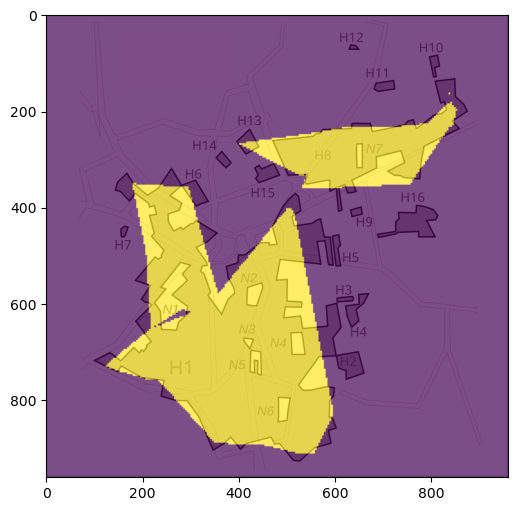

In [9]:
viz_descision_boundary(model)

In [10]:
torch.save(model.state_dict(), '../models/8_8_1.pth')

# [16, 16]

In [ ]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([16, 16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/200], Loss: 0.1843, Accuracy: 0.8804
Epoch [20/200], Loss: 0.1728, Accuracy: 0.8868
Epoch [30/200], Loss: 0.1564, Accuracy: 0.8791
Epoch [40/200], Loss: 0.1534, Accuracy: 0.8860


In [ ]:
viz_descision_boundary(model)

In [ ]:
torch.save(model.state_dict(), '../models/16_16_1.pth')

## [16, 16, 16]

In [ ]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([16, 16, 16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
viz_descision_boundary(model)

In [ ]:
torch.save(model.state_dict(), '../models/16_16_16_1.pth')

## [64]

In [ ]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
viz_descision_boundary(model)

In [ ]:
torch.save(model.state_dict(), '../models/64_1.pth')

## [ 32 32 32]

In [29]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([32, 32, 32]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 3000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [150/3000], Loss: 0.0782, Accuracy: 0.9466
Epoch [300/3000], Loss: 0.0690, Accuracy: 0.9614
Epoch [450/3000], Loss: 0.0626, Accuracy: 0.9709
Epoch [600/3000], Loss: 0.0625, Accuracy: 0.9708
Epoch [750/3000], Loss: 0.0503, Accuracy: 0.9687
Epoch [900/3000], Loss: 0.0603, Accuracy: 0.9778
Epoch [1050/3000], Loss: 0.0414, Accuracy: 0.9739
Epoch [1200/3000], Loss: 0.0398, Accuracy: 0.9792
Epoch [1350/3000], Loss: 0.0430, Accuracy: 0.9587
Epoch [1500/3000], Loss: 0.0393, Accuracy: 0.9697
Epoch [1650/3000], Loss: 0.0374, Accuracy: 0.9680
Epoch [1800/3000], Loss: 0.0349, Accuracy: 0.9724
Epoch [1950/3000], Loss: 0.0392, Accuracy: 0.9776
Epoch [2100/3000], Loss: 0.0356, Accuracy: 0.9841
Epoch [2250/3000], Loss: 0.0341, Accuracy: 0.9760
Epoch [2400/3000], Loss: 0.0369, Accuracy: 0.9668
Epoch [2550/3000], Loss: 0.0340, Accuracy: 0.9842
Epoch [2700/3000], Loss: 0.0318, Accuracy: 0.9805
Epoch [2850/3000], Loss: 0.0335, Accuracy: 0.9548
Epoch [3000/3000], Loss: 0.0335, Accuracy: 0.9786


<Figure size 640x480 with 0 Axes>

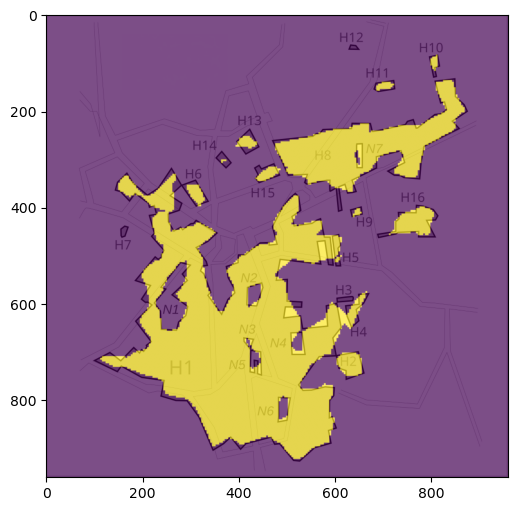

In [30]:
viz_descision_boundary(model)

In [31]:
torch.save(model.state_dict(), '../models/32_32_32_1.pth')

## [64, 64, 64]

In [11]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([64, 64, 64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 1000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [50/1000], Loss: 0.0480, Accuracy: 0.9796
Epoch [100/1000], Loss: 0.0409, Accuracy: 0.9826
Epoch [150/1000], Loss: 0.0302, Accuracy: 0.9744
Epoch [200/1000], Loss: 0.0310, Accuracy: 0.9869
Epoch [250/1000], Loss: 0.0255, Accuracy: 0.9885
Epoch [300/1000], Loss: 0.0224, Accuracy: 0.9823
Epoch [350/1000], Loss: 0.0216, Accuracy: 0.9900
Epoch [400/1000], Loss: 0.0186, Accuracy: 0.9839
Epoch [450/1000], Loss: 0.0173, Accuracy: 0.9912
Epoch [500/1000], Loss: 0.0188, Accuracy: 0.9903
Epoch [550/1000], Loss: 0.0185, Accuracy: 0.9812
Epoch [600/1000], Loss: 0.0190, Accuracy: 0.9753
Epoch [650/1000], Loss: 0.0148, Accuracy: 0.9907
Epoch [700/1000], Loss: 0.0188, Accuracy: 0.9905
Epoch [750/1000], Loss: 0.0159, Accuracy: 0.9915
Epoch [800/1000], Loss: 0.0159, Accuracy: 0.9874
Epoch [850/1000], Loss: 0.0144, Accuracy: 0.9908
Epoch [900/1000], Loss: 0.0130, Accuracy: 0.9902
Epoch [950/1000], Loss: 0.0206, Accuracy: 0.9864
Epoch [1000/1000], Loss: 0.0152, Accuracy: 0.9877


<Figure size 640x480 with 0 Axes>

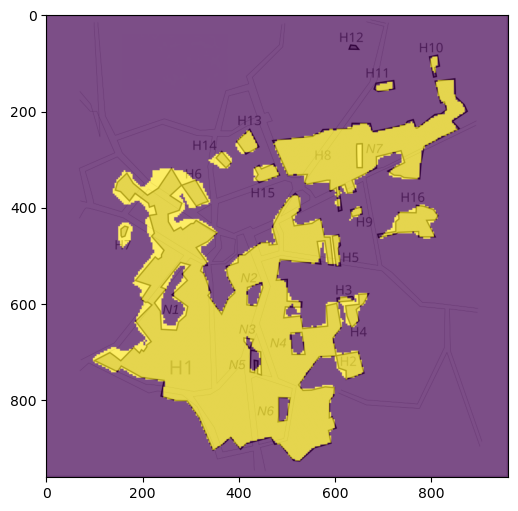

In [12]:
viz_descision_boundary(model)

In [14]:
torch.save(model.state_dict(), '../models/64_64_64_1.pth')

## 24 24 24 24

In [26]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([24, 24, 24, 24]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 3000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [150/3000], Loss: 0.0470, Accuracy: 0.9664
Epoch [300/3000], Loss: 0.0371, Accuracy: 0.9635
Epoch [450/3000], Loss: 0.0279, Accuracy: 0.9826
Epoch [600/3000], Loss: 0.0314, Accuracy: 0.9778
Epoch [750/3000], Loss: 0.0235, Accuracy: 0.9819
Epoch [900/3000], Loss: 0.0228, Accuracy: 0.9886
Epoch [1050/3000], Loss: 0.0224, Accuracy: 0.9829
Epoch [1200/3000], Loss: 0.0209, Accuracy: 0.9840
Epoch [1350/3000], Loss: 0.0205, Accuracy: 0.9909
Epoch [1500/3000], Loss: 0.0186, Accuracy: 0.9899
Epoch [1650/3000], Loss: 0.0173, Accuracy: 0.9793
Epoch [1800/3000], Loss: 0.0188, Accuracy: 0.9893
Epoch [1950/3000], Loss: 0.0183, Accuracy: 0.9904
Epoch [2100/3000], Loss: 0.0148, Accuracy: 0.9887
Epoch [2250/3000], Loss: 0.0186, Accuracy: 0.9870
Epoch [2400/3000], Loss: 0.0157, Accuracy: 0.9914
Epoch [2550/3000], Loss: 0.0159, Accuracy: 0.9906
Epoch [2700/3000], Loss: 0.0142, Accuracy: 0.9929
Epoch [2850/3000], Loss: 0.0128, Accuracy: 0.9929
Epoch [3000/3000], Loss: 0.0147, Accuracy: 0.9889


<Figure size 640x480 with 0 Axes>

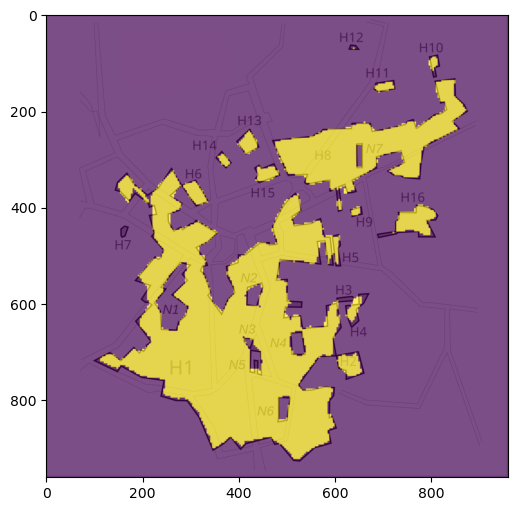

In [27]:
viz_descision_boundary(model)

In [28]:
torch.save(model.state_dict(), '../models/24_24_24_24_1.pth')

## 32 32 32 32

In [22]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([32, 32, 32, 32]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 3000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [150/3000], Loss: 0.0454, Accuracy: 0.9714
Epoch [300/3000], Loss: 0.0303, Accuracy: 0.9801
Epoch [450/3000], Loss: 0.0252, Accuracy: 0.9866
Epoch [600/3000], Loss: 0.0265, Accuracy: 0.9862
Epoch [750/3000], Loss: 0.0246, Accuracy: 0.9831
Epoch [900/3000], Loss: 0.0163, Accuracy: 0.9913
Epoch [1050/3000], Loss: 0.0145, Accuracy: 0.9876
Epoch [1200/3000], Loss: 0.0147, Accuracy: 0.9904
Epoch [1350/3000], Loss: 0.0138, Accuracy: 0.9843
Epoch [1500/3000], Loss: 0.0142, Accuracy: 0.9899
Epoch [1650/3000], Loss: 0.0132, Accuracy: 0.9921
Epoch [1800/3000], Loss: 0.0128, Accuracy: 0.9921
Epoch [1950/3000], Loss: 0.0125, Accuracy: 0.9943
Epoch [2100/3000], Loss: 0.0111, Accuracy: 0.9918
Epoch [2250/3000], Loss: 0.0097, Accuracy: 0.9949
Epoch [2400/3000], Loss: 0.0119, Accuracy: 0.9933
Epoch [2550/3000], Loss: 0.0111, Accuracy: 0.9915
Epoch [2700/3000], Loss: 0.0142, Accuracy: 0.9906
Epoch [2850/3000], Loss: 0.0152, Accuracy: 0.9855
Epoch [3000/3000], Loss: 0.0079, Accuracy: 0.9950


<Figure size 640x480 with 0 Axes>

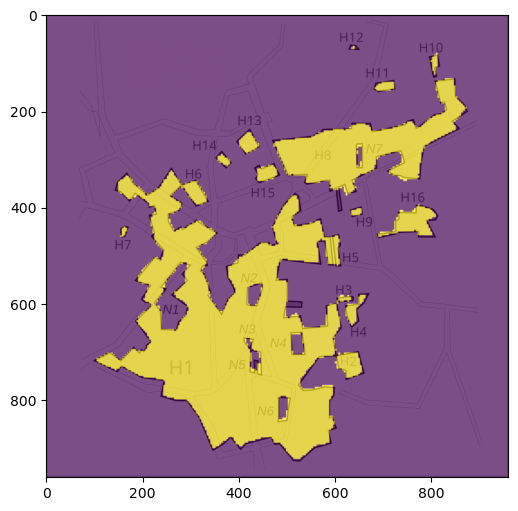

In [23]:
viz_descision_boundary(model)

In [24]:
torch.save(model.state_dict(), '../models/32_32_32_32_1.pth')

## 64 64 64 64

In [15]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([64, 64, 64, 64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 1000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [50/1000], Loss: 0.0300, Accuracy: 0.9790
Epoch [100/1000], Loss: 0.0217, Accuracy: 0.9835
Epoch [150/1000], Loss: 0.0166, Accuracy: 0.9926
Epoch [200/1000], Loss: 0.0166, Accuracy: 0.9899
Epoch [250/1000], Loss: 0.0101, Accuracy: 0.9959
Epoch [300/1000], Loss: 0.0105, Accuracy: 0.9952
Epoch [350/1000], Loss: 0.0101, Accuracy: 0.9955
Epoch [400/1000], Loss: 0.0066, Accuracy: 0.9952
Epoch [450/1000], Loss: 0.0086, Accuracy: 0.9909
Epoch [500/1000], Loss: 0.0049, Accuracy: 0.9974
Epoch [550/1000], Loss: 0.0053, Accuracy: 0.9970
Epoch [600/1000], Loss: 0.0070, Accuracy: 0.9959
Epoch [650/1000], Loss: 0.0038, Accuracy: 0.9961
Epoch [700/1000], Loss: 0.0029, Accuracy: 0.9990
Epoch [750/1000], Loss: 0.0087, Accuracy: 0.9970
Epoch [800/1000], Loss: 0.0031, Accuracy: 0.9986
Epoch [850/1000], Loss: 0.0016, Accuracy: 0.9999
Epoch [900/1000], Loss: 0.0026, Accuracy: 0.9979
Epoch [950/1000], Loss: 0.0064, Accuracy: 0.9934
Epoch [1000/1000], Loss: 0.0034, Accuracy: 0.9983


<Figure size 640x480 with 0 Axes>

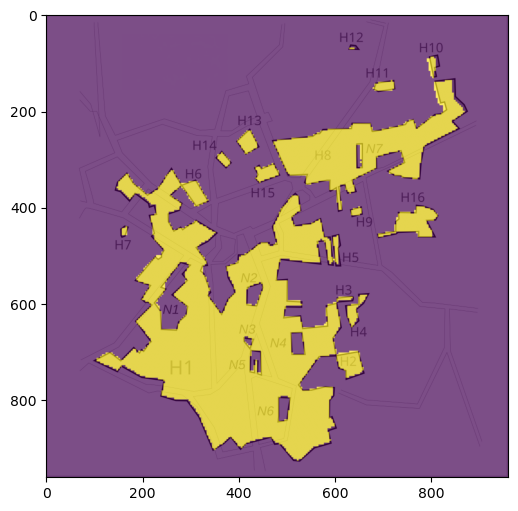

In [16]:
viz_descision_boundary(model)

In [18]:
torch.save(model.state_dict(), '../models/64_64_64_64_1.pth')